In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cvxpy as cp

from interval import interval, inf, imath

from safe_train import *
from projection_examples import projection_training_loop

Instructions for updating:
non-resource variables are not supported in the long term


/Users/nishant/Documents/Marabou/maraboupy/Marabou.py:31: UserWarning: ONNX parser is unavailable because onnx or onnxruntime packages are not installed
  warnings.warn("ONNX parser is unavailable because onnx or onnxruntime packages are not installed")


## Generate data

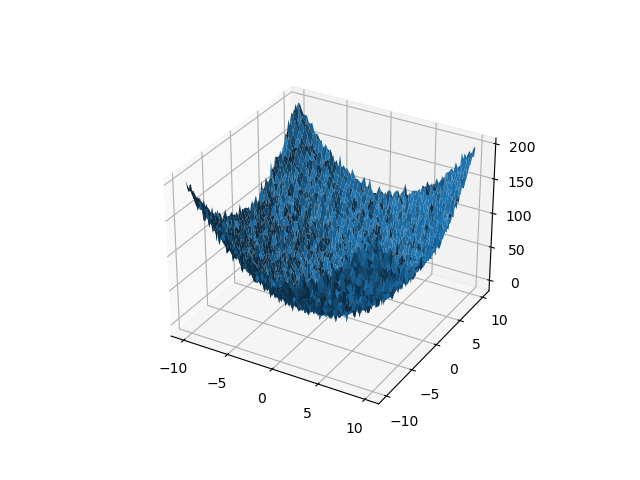

In [2]:
NOISE_STD = 5
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x,y)
z = x**2 + y**2 + np.random.standard_normal(x.shape)*NOISE_STD

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
ax.plot_surface(x, y, z)
# ax.set_zlim(-1, 101)
plt.show()

In [3]:
x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array = z.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

## Train network

In [4]:
normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        # layers.Dense(units=2, activation="linear", input_shape=[2]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)

history = regression_model.fit(
    nn_x,
    z_array,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

Metal device set to: Apple M1 Pro
Epoch 1/10
282/282 [==============================] - 3s 10ms/step - loss: 445.3982 - val_loss: 204.3820
Epoch 2/10
282/282 [==============================] - 2s 8ms/step - loss: 55.6593 - val_loss: 201.9346
Epoch 3/10
282/282 [==============================] - 2s 8ms/step - loss: 45.9924 - val_loss: 823.2620
Epoch 4/10
282/282 [==============================] - 2s 8ms/step - loss: 64.2802 - val_loss: 57.5499
Epoch 5/10
282/282 [==============================] - 2s 8ms/step - loss: 50.1696 - val_loss: 122.1575
Epoch 6/10
282/282 [==============================] - 2s 9ms/step - loss: 47.6504 - val_loss: 34.1547
Epoch 7/10
282/282 [==============================] - 2s 8ms/step - loss: 51.3785 - val_loss: 444.9198
Epoch 8/10
282/282 [==============================] - 2s 8ms/step - loss: 45.9648 - val_loss: 62.1997
Epoch 9/10
282/282 [==============================] - 2s 8ms/step - loss: 47.6664 - val_loss: 124.2174
Epoch 10/10
282/282 [===================

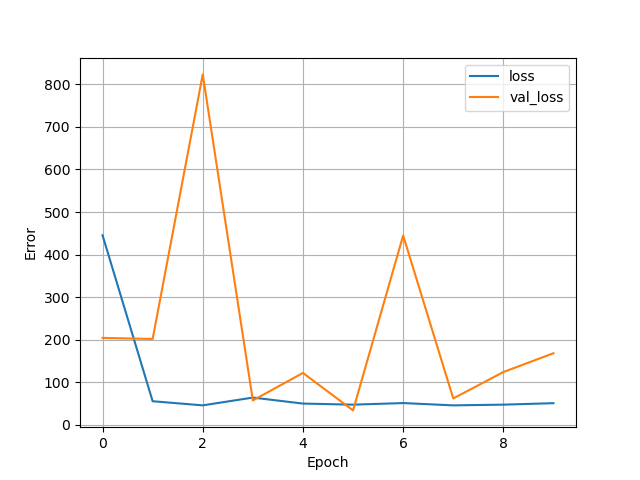

In [5]:
plot_loss(history)

In [6]:
z_predict = regression_model.predict(nn_x)
z_predict_mesh = z_predict.reshape(100, 100)

313/313 [==============================] - 1s 3ms/step


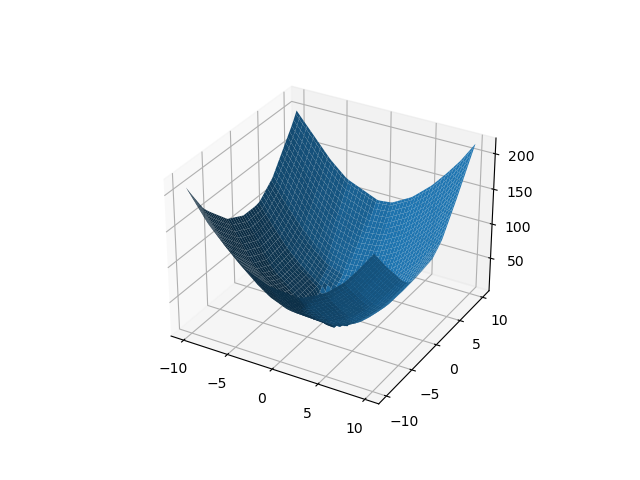

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.plot_surface(x, y, z_predict_mesh)

# surf1._edgecolors2d = surf1._edgecolor3d
# surf1._facecolors2d = surf1._facecolor3d

plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

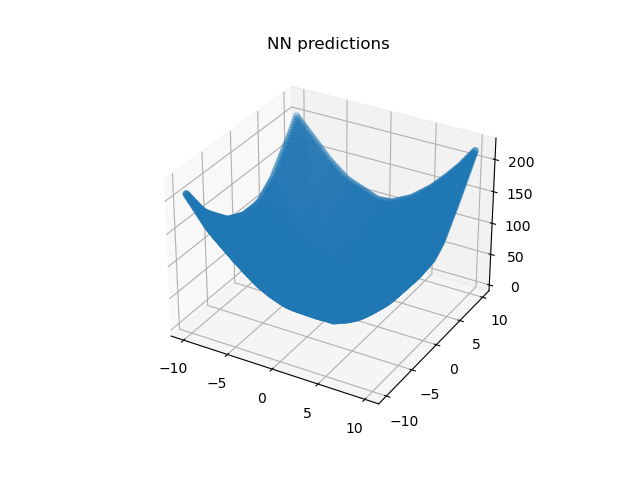

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.scatter(x, y, z_predict_mesh)

plt.title("NN predictions")
plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

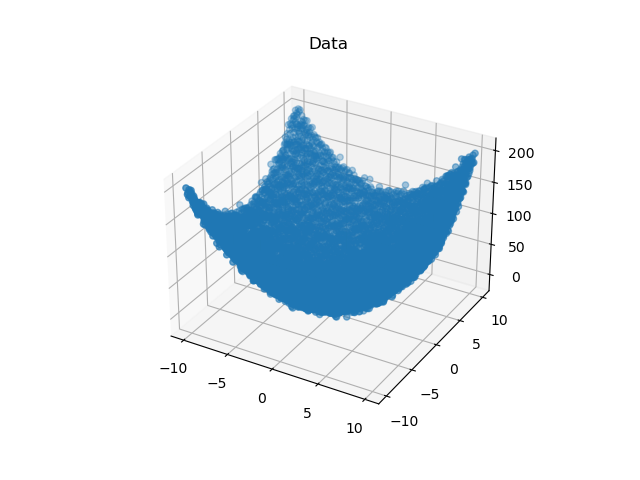

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf2 = ax.scatter(x, y, z)
plt.title("Data")
plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

## Analyze safety with interval tool: bowl

In [129]:
desired_interval = [interval[-8, -5] ** 2 + interval[-8, -5] ** 2]
desired_interval

[interval([50.0, 128.0])]

In [130]:
regression_model.predict([-8, -8])

1/1 [==============================] - 0s 90ms/step


array([[123.653404]], dtype=float32)

In [131]:
regression_model.predict([-5, -5])

1/1 [==============================] - 0s 21ms/step


array([[46.399456]], dtype=float32)

In [132]:
input_interval = [interval[-8, -5], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([43.54111861090381, 131.44611844054037])]

In [133]:
penultimate_interval

[interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 3.046413589077533]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([26.18630903645554, 86.88003510991149]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([21.61245672055165, 70.26317395475664]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]

In [134]:
x.reshape(-1).shape

(10000,)

In [135]:
z_predict.shape

(10000, 1)

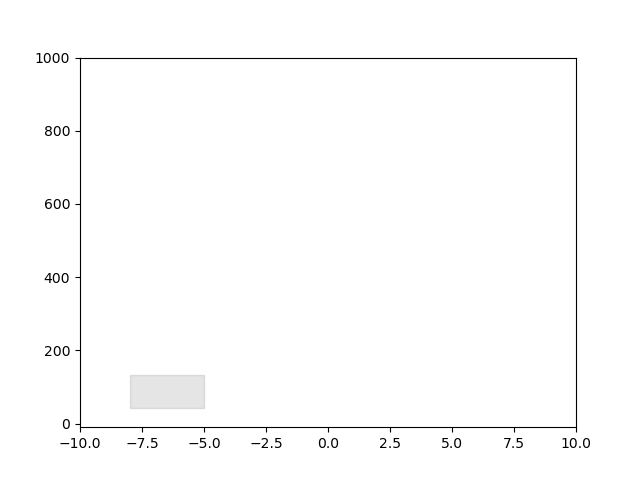

In [136]:
plot_intervals(input_interval[0], output_interval, xlim = [-10, 10], ylim = [-10, 1000])

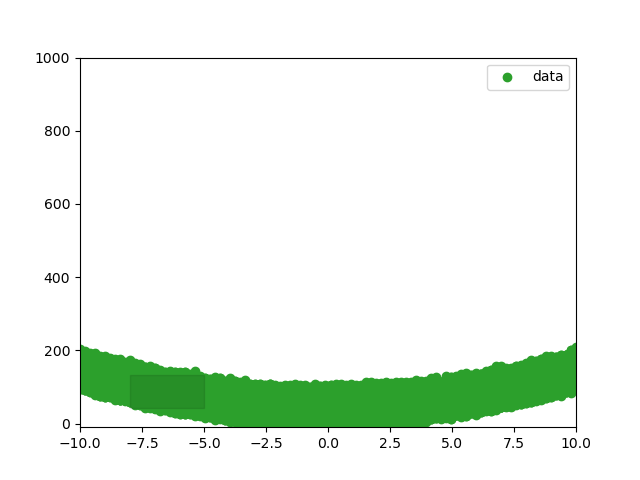

In [137]:
plot_intervals(input_interval[0], output_interval, xs = x_array, ys = z_array, xlim = [-10, 10], ylim = [-10, 1000])

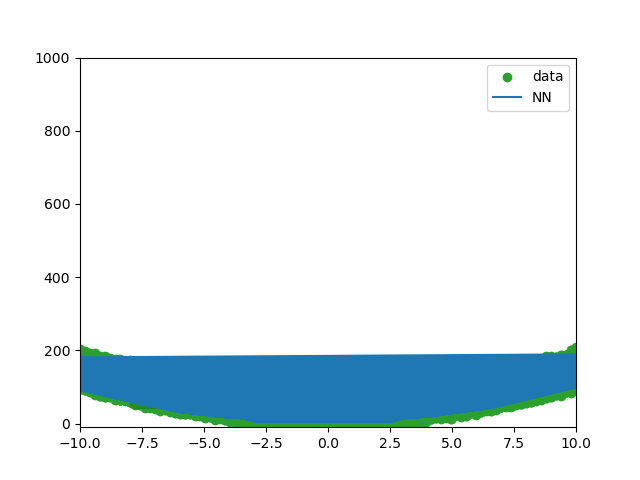

In [138]:
plot_intervals(input_interval[0], output_interval, xs = x_array, ys = z_array, y_predict = z_predict, xlim = [-10, 10], ylim = [-10, 1000])

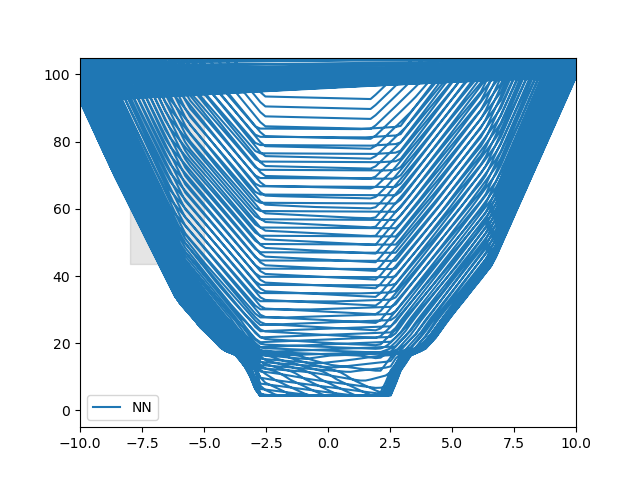

In [139]:
plot_intervals(input_interval[0], output_interval, xs=x.reshape(-1), y_predict=z_predict, xlim=[-10, 10], ylim=[-5, 105])

## Projecting weights

In [140]:
output_interval

[interval([43.54111861090381, 131.44611844054037])]

In [141]:
intervals_to_project = []
assert type(output_interval) == type(desired_interval)
if type(output_interval) is list:
    assert len(output_interval) == len(desired_interval)
    for i in range(len(output_interval)):
        if (
            desired_interval[i] is not None
            and output_interval[i] not in desired_interval[i]
        ):
            intervals_to_project.append(i)
else:
    intervals_to_project.append(0)
    
print(f"Projecting intervals at indices {intervals_to_project}")
    
weights_tf = regression_model.layers[-1].weights
weights_np = weights_tf[0].numpy()
biases_np = weights_tf[1].numpy()

for idx in intervals_to_project:
    weights_to_project = np.hstack(
        [weights_np[:, idx], biases_np[idx]]
    )
    proj = project_weights(
        desired_interval[idx],
        penultimate_interval,
        weights_to_project,
    )
    weights_np[:, idx] = proj[:-1]
    biases_np[idx] = proj[-1]

regression_model.layers[-1].set_weights([weights_np, biases_np])

Projecting intervals at indices [0]


In [142]:
output_interval, _ = propagate_interval(
    [interval[-8, -5], interval[-8, -5]],
    regression_model,
    graph=False,
)
print(f"After projecting, output interval is {output_interval}")

z_predict = regression_model.predict(nn_x)
z_predict_mesh = z_predict.reshape(100, 100)

After projecting, output interval is [interval([49.99999967778435, 127.99999994304311])]
313/313 [==============================] - 1s 3ms/step


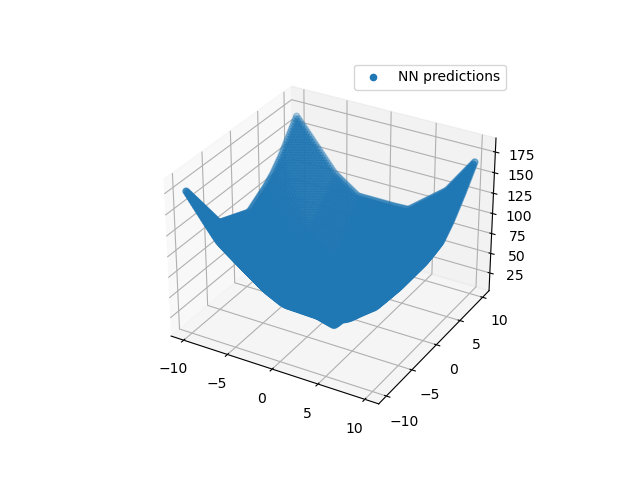

In [143]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
surf1 = ax.scatter(x, y, z_predict_mesh)
# surf2 = ax.scatter(x, y, z)

# ax.legend(["NN predictions", "Data"])
ax.legend(["NN predictions"])
plt.show()
# plt.plot(x, y_predict, color="C1")
# plt.scatter(x, y, color="C2")
# plt.show()

TODO: figure out a different way of analyzing the new weights

## Simpler problem to troubleshoot: linear in 3-space

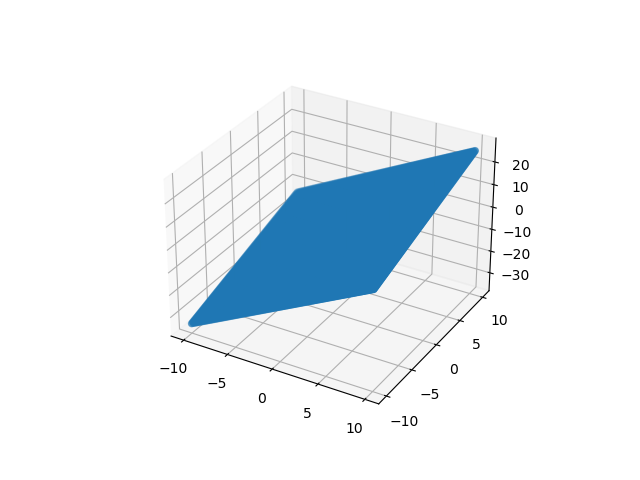

In [20]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
z_func = lambda x, y: 2*x + y - 4

x, y = np.meshgrid(x,y)
z_array = z_func(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plt.scatter(x, y, z)
ax.scatter(x, y, z_array)
plt.show()

In [21]:
x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array_long = z_array.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

In [22]:
normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=2, activation="linear", input_shape=[2]),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=64, activation="relu"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)

history = regression_model.fit(
    nn_x,
    z_array_long,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

Epoch 1/10
282/282 [==============================] - 2s 5ms/step - loss: 6.9325 - val_loss: 4.3487e-12
Epoch 2/10
282/282 [==============================] - 1s 5ms/step - loss: 4.2049e-12 - val_loss: 9.9840e-13
Epoch 3/10
282/282 [==============================] - 2s 6ms/step - loss: 5.8591e-13 - val_loss: 1.1637e-12
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 5.8646e-13 - val_loss: 1.1637e-12
Epoch 5/10
282/282 [==============================] - 2s 5ms/step - loss: 6.4796e-13 - val_loss: 7.5567e-13
Epoch 6/10
282/282 [==============================] - 1s 5ms/step - loss: 6.1640e-13 - val_loss: 1.0952e-12
Epoch 7/10
282/282 [==============================] - 1s 5ms/step - loss: 6.6587e-13 - val_loss: 8.8087e-13
Epoch 8/10
282/282 [==============================] - 1s 5ms/step - loss: 7.6937e-13 - val_loss: 1.4226e-12
Epoch 9/10
282/282 [==============================] - 1s 5ms/step - loss: 8.9739e-13 - val_loss: 1.2403e-12
Epoch 10/10
282/282 [===========

In [23]:
regression_model.predict([-8, -8])

1/1 [==============================] - 0s 56ms/step


array([[-28.]], dtype=float32)

In [24]:
z_func(*[-8, -8])

-28

In [25]:
regression_model.predict([-5, -5])

1/1 [==============================] - 0s 17ms/step


array([[-19.]], dtype=float32)

In [26]:
z_func(*[-5, -5])

-19

In [27]:
z_func(*[-1, -1])

-7

In [28]:
z_func(*[0, 0])

-4

In [29]:
input_interval = [interval[-8, -5], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-27.999999861594453, -18.999999834174524])]

In [30]:
input_interval = [interval[0, inf], interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-11.999999851490642, inf])]

In [31]:
input_interval = [None, interval[-8, -5]]
output_interval, penultimate_interval = propagate_interval(input_interval, regression_model)
output_interval

[interval([-11.999999844040062, -8.99999982040906])]

## Test training
takeaway: make sure `shapes` match for `y, y_pred` passed to loss function. even `(100, 1)` and `(100,)` mismatch will lead to bad learning.

### Multiple regression: x, y, z

In [ ]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
z = x**2 + y**2

x_array = x.reshape(-1, 1)
y_array = y.reshape(-1, 1)
z_array = z.reshape(-1, 1)
nn_x = np.hstack([x_array, y_array])

input_interval = [interval[-8, -5], interval[-8, -5]]
desired_interval = interval[-28, -19]

normalizer = layers.Normalization(
    input_shape=[
        2,
    ],
    axis=-1,
)
normalizer.adapt(nn_x)
regression_model = tf.keras.Sequential(
    [
        normalizer,
        # layers.Dense(units=2, activation="linear", input_shape=[2]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss_fn = tf.keras.losses.MeanSquaredError()

# don't project every epoch
EPOCH_TO_PROJECT = 5

epochs = 40
# epochs = 5
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")

    with tf.GradientTape() as tape:
        z_pred = regression_model(nn_x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = loss_fn(z_array, z_pred)

    # Compute gradients
    trainable_vars = regression_model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # print(gradients)
    # print(trainable_vars)
    # Update weights
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    output_interval, penultimate_interval = propagate_interval(
        input_interval, regression_model, graph=False
    )
    if type(output_interval) is list:
        if len(output_interval) == 1:
            output_interval = output_interval[0]
        else:
            raise NotImplementedError("Output interval was interval of length > 1")
    if output_interval not in desired_interval:
        print(f"safe region test FAILED, interval was {output_interval}")
        print(regression_model.layers[-1].weights)
        if epoch % EPOCH_TO_PROJECT == 0:
            print(f"\nProjecting weights at epoch {epoch}.")
            weights = regression_model.layers[-1].weights
            print(
                f"Old weights: {np.squeeze(np.array([weight.numpy() for weight in weights]))}"
            )
            projected_weights = project_weights(
                desired_interval,
                penultimate_interval,
                np.squeeze(np.array(weights)),
            )
            print(
                f"Projected weights: {projected_weights} yield new interval: "
                f"{penultimate_interval * projected_weights[0] + projected_weights[1]}"
            )
            proj_weight, proj_bias = projected_weights
            regression_model.layers[-1].set_weights(
                [np.array([[proj_weight]]), np.array([proj_bias])]
            )
            # NOTE: assume positive weights
            # TODO: handle both signs of weights

            # print(optimizer.get_weights())
            # optimizer.set_weights(last_safe_weights)
    else:
        print(f"safe region test passed, interval was {output_interval}")

    # Update metrics (includes the metric that tracks the loss)
    regression_model.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value

In [ ]:
test_interval = [interval([0.17749245743887973, 40.715509778405405]), interval([1.3693407866030003, 39.00241526956424]), interval([0.0]), interval([0.0, 2.8528582891451904]), interval([0.0, 0.8297828604382264]), interval([0.0, 26.46248532465599]), interval([0.0]), interval([5.1643618056622325, 51.965985161668776]), interval([0.0, 4.449784483001119]), interval([0.0, 12.181961657602645]), interval([1.1487307343228501, 36.84628332367279]), interval([0.0]), interval([0.0, 10.67893006000102]), interval([0.0, 32.31041089071087]), interval([0.0, 4.428521101926773]), interval([0.0, 33.27413406123338]), interval([0.0, 1.173106527682179]), interval([0.0, 5.763051345125981]), interval([0.0]), interval([0.0, 0.0593642406942681]), interval([1.1042434945592472, 42.40602482858007]), interval([0.0, 48.153185864747876]), interval([0.0, 2.093169161648054]), interval([0.0, 1.5303758911667666]), interval([1.5546250524211334, 41.40633134363574]), interval([1.2690299589762726, 44.50031948515337]), interval([0.0, 8.2281692197887]), interval([0.0, 0.3814058534273029]), interval([0.0, 29.90513713529191]), interval([0.0, 33.562458829446015]), interval([0.0, 0.7613352551489034]), interval([0.0, 38.30264206972309]), interval([0.0]), interval([0.0, 6.324824304874891]), interval([2.4997606995947597, 37.87439927718122]), interval([2.5371649489848416, 42.506682277456136]), interval([0.002846090267297985, 42.09635439199396]), interval([0.0]), interval([0.0, 0.6057659663937741]), interval([0.0, 12.80103993487166]), interval([0.0, 19.2486105128124]), interval([0.0, 37.93811481829238]), interval([2.968866596288945, 45.56460879954275]), interval([4.537518103822291, 51.34208899504068]), interval([0.0, 10.83174511415565]), interval([0.0, 0.2774448181623927]), interval([0.0]), interval([0.0, 29.00540786959906]), interval([0.08301538662180619, 35.51933660793823]), interval([1.0847326840759233, 38.7511647446967]), interval([0.0, 39.20136368640528]), interval([0.0, 42.341402156523365]), interval([0.0, 34.25962623911843]), interval([0.0, 48.34615648698638]), interval([2.4355944472457822, 39.57223969649944]), interval([0.0, 13.039277868905055]), interval([0.0, 4.195586380412922]), interval([0.0]), interval([0.0, 3.050183749047207]), interval([0.0]), interval([0.0, 0.1519885564424282]), interval([0.6696018918771051, 34.230603299831806]), interval([0.0, 30.686249110719995]), interval([5.5374481194296585, 50.683586670818116])]
len(test_interval)

### 2 dimensional

In [ ]:
x, y = generate_data(NOISE_STD=0.5, n=128)
plt.figure()
plt.scatter(x, y)
plt.show()

### With `model.fit`

Works perfectly, as expected

In [ ]:
normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
normalizer.adapt(x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=1, activation="linear", input_shape=[1]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error"
)
history = regression_model.fit(
    x,
    y,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 10% of the training data.
    validation_split=0.1,
)

plot_loss(history)

y_pred = regression_model.predict(x)

plt.figure()
plt.scatter(x, y_pred)
plt.scatter(x, y)
plt.legend(["nn", "data"])
plt.show()

### Manual

#### Batching

In [ ]:
nums = np.arange(10, 20)
nums

In [ ]:
rng = np.random.default_rng()
train_indices = np.arange(nums.shape[0])
rng.shuffle(train_indices)
train_indices

In [ ]:
nums[train_indices]

In [ ]:
## set up batches
rng = np.random.default_rng()
batch_size = 32

train_dataset = np.vstack([x,y]).T
train_dataset

rng.shuffle(train_dataset)  # in-place

x_shuffled = train_dataset[:, 0]
y_shuffled = train_dataset[:, 1]

x_batched = np.split(x_shuffled, np.arange(batch_size,len(x_shuffled),batch_size))
y_batched = np.split(y_shuffled, np.arange(batch_size,len(y_shuffled),batch_size))

dataset_batched = list(zip(x_batched, y_batched))

#### Train loop

In [ ]:
normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
normalizer.adapt(x)
regression_model = tf.keras.Sequential(
    [
        normalizer, 
        layers.Dense(units=1, activation="linear", input_shape=[1]),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=64, activation="relu"),
        layers.Dense(units=8, activation="relu"),
        # layers.Dense(units=10, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
loss_fn = tf.keras.losses.MeanSquaredError()

# don't project every epoch
EPOCH_TO_PROJECT = 5

# epochs = 500
epochs = 50
epoch_fraction = 0.1
report_every_epoch = int(epochs * epoch_fraction)
for epoch in range(epochs):
    # if epoch % report_every_epoch == 0:
        # print(f"on epoch {epoch}")
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = regression_model(x_batch_train, training=True)  # Forward pass
            # IMPORTANT: squeeze to match dimensions before passing to loss
            y_pred = tf.squeeze(y_pred)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = loss_fn(y_batch_train, y_pred)

        # Compute gradients
        trainable_vars = regression_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # print(gradients)
        # print(trainable_vars)
        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
# print(f"done training")
        
y_pred = regression_model.predict(x)

plt.figure()
plt.scatter(x, y_pred)
plt.scatter(x, y)
plt.legend(["nn", "data"])
plt.show()        

In [ ]:
out, penum = propagate_interval(interval[10, 20], regression_model)
out

In [ ]:
penum

In [ ]:
# true function
interval[10, 20] * 0.5 + 5

## Projection with multiple final nodes

In [ ]:
input_intervals = penum
input_intervals

In [ ]:
weights = regression_model.layers[-1].weights
weights

In [ ]:
theta = np.squeeze(np.vstack([weight.numpy() for weight in weights]).flatten())
theta

In [ ]:
goal_interval = interval[10, 15]
goal_interval

In [ ]:
goal_interval

In [ ]:
input_intervals

In [ ]:
elems = []
for elem in input_intervals:
    if elem[0][0] == elem[0][1]:
        elems.append((elem[0][0],))
    else:
        elems.append(elem[0])
elems

In [ ]:
import time

In [ ]:
t1 = time.time()
proj = project_weights(goal_interval, input_intervals, theta, verbose=False)
t2 = time.time() - t1
print(t2)
proj

In [ ]:
proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += input_intervals[i] * weight
proj_out += proj[-1]
proj_out

In [ ]:
input_intervals = [interval[28.3, 49.1], interval[1, 3]]

In [ ]:
# input_intervals = [interval[28.3, 49.1], interval[2, 5]]

In [ ]:
theta = np.array([0.148, 0.377, 1.79])

In [ ]:
input_intervals[0] * theta[0] + input_intervals[1]*theta[1] + theta[2]

In [ ]:
x = cp.Variable(theta.shape)
x

In [ ]:
import itertools

test = list(itertools.product(*[(elem[0]) for elem in input_intervals]))
test

In [ ]:
[np.hstack([elem, 1]) for elem in test]

In [ ]:
goal_interval[0][0]

In [ ]:
goal_interval[0][1]

In [ ]:
def generate_constraints(input_intervals, goal_interval, x):
    interval_combinations = list(itertools.product(
        *[(elem[0]) for elem in input_intervals]))
    constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
    constraints = []
    print("Generating constraints:")
    for i, constraint_vector in enumerate(constraint_vectors):
        print(f"{constraint_vector} @ x >= {goal_interval[0][0]}")
        constraints.append(constraint_vector @ x >= goal_interval[0][0])
        print(f"{constraint_vector} @ x <= {goal_interval[0][1]}")
        constraints.append(constraint_vector @ x <= goal_interval[0][1])
    return constraints

In [ ]:
input_intervals

In [ ]:
x = cp.Variable((3,))
constraints = generate_constraints(input_intervals, goal_interval, x)
# constraints = [
#     np.array([28.3, 1, 1]) @ x >= 10,
#     np.array([49.1, 3, 1]) @ x <= 15,
#     np.array([28.3, 3, 1]) @ x >= 10,
#     np.array([49.1, 1, 1]) @ x <= 15,
# ]

obj = cp.Minimize(
    cp.norm(x - np.array([0.158, 0.377, 1.79]))
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal variables are: {np.round(x.value, 5)}")
print(f"took {tfinish - tstart} seconds")

In [ ]:
shift_lower = np.array(([0] * len(input_intervals)) + [goal_interval[0].inf])
shift_lower

In [ ]:
direction_lower = np.array([1] + [-input_interval[0].inf for input_interval in input_intervals][::-1])
direction_lower

In [ ]:
project_lower = (
    (direction_lower @ (theta - shift_lower))
    / (direction_lower @ direction_lower)
    * direction_lower
)
project_lower

In [ ]:
param_lower = project_lower + shift_lower
param_lower

In [ ]:
shift_upper = np.array(([0] * len(input_intervals)) + [goal_interval[0].sup])
shift_upper

In [ ]:
# direction_upper = np.array([1] + [-input_interval[0].sup for input_interval in input_intervals])
direction_upper = np.array([1] + [-input_interval[0].sup for input_interval in input_intervals][::-1])
direction_upper

In [ ]:
project_upper = (
    (direction_upper @ (theta - shift_upper))
    / (direction_upper @ direction_upper)
    * direction_upper
)
project_upper

In [ ]:
param_upper = project_upper + shift_upper
param_upper

In [ ]:
theta

In [ ]:
best_params = min([param_upper, param_lower], key=lambda param: np.linalg.norm(theta - param))
best_params

In [ ]:
input_intervals[0] * best_params[0] + input_intervals[1] * best_params[1] + best_params[2]

In [ ]:
input_intervals = [interval[28.3, 49.1], interval[0]]
input_intervals

In [ ]:
best_params = [0.240385, 0.377, 3.19712]
best_params

In [ ]:
input_intervals[0] * 0.158 + 1.79

In [ ]:
input_intervals[0] * best_params[0] + input_intervals[1] * best_params[1] + best_params[2]

In [ ]:
interval[28.3, 49.1] * 0.289699 + interval[1,3] * -0.512874 + 2.31438

In [ ]:
interval[28.3, 49.1] * 0.240385 + interval[0] * .377 + 3.19712

In [ ]:
28.3 * 0.289699 + 1 * -0.512874 + 2.31438

In [ ]:
49.1 * 0.289699 + 3 * -0.512874 + 2.31438

In [ ]:
projection_training_loop()

## CVXpy

### individual variables

In [ ]:
x = cp.Variable()
y = cp.Variable()
z = cp.Variable()

constraints = [
    28.3 * x + 1 * y + z >= 10,
    49.1 * x + 3 * y + z <= 15,
    # 28.3 * x + 3 * y + z >= 10,
    # 49.1 * x + 1 * y + z <= 15
]

obj = cp.Minimize(
    (x - 0.158)**2 + (y - .377)**2 + (z - 1.79)**2
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal variables are x: {np.round(x.value, 5)}, y: {np.round(y.value, 5)}, z: {np.round(z.value, 5)}")
print(f"took {tfinish - tstart} seconds")

### vectorized version

In [ ]:
x = cp.Variable((3,))

constraints = [
    np.array([28.3, 1, 1]) @ x >= 10,
    np.array([49.1, 3, 1]) @ x <= 15,
    # 28.3 * x + 3 * y + z >= 10,
    # 49.1 * x + 1 * y + z <= 15
]

obj = cp.Minimize(
    cp.norm(x - np.array([0.158, 0.377, 1.79]))
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal values are: {np.round(x.value, 5)}")
print(f"took {tfinish - tstart} seconds")

interval[28.3, 49.1] * x.value[0] + interval[1,3] * x.value[1] + x.value[2]

In [ ]:
x = cp.Variable((3,))

constraints = [
    np.array([28.3, 1, 1]) @ x >= 10,
    np.array([49.1, 3, 1]) @ x <= 15,
    np.array([1, 0, 0]) @ x >= 0,
    np.array([0, 1, 0]) @ x >= 0,
]

obj = cp.Minimize(
    cp.norm(x - np.array([0.158, 0.377, 1.79]))
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal values are: {np.round(x.value, 5)}")
print(f"took {tfinish - tstart} seconds")

interval[28.3, 49.1] * x.value[0] + interval[1,3] * x.value[1] + x.value[2]

In [ ]:
interval[28.3, 49.1] * x.value[0] + interval[1,3] * x.value[1] + x.value[2]

In [ ]:
input_intervals = [interval[28.3, 49.1], interval[1, 3], interval[0]]
[(elem[0]) for elem in input_intervals]

In [ ]:
input_intervals[2][0][1]

In [ ]:
for idx in range(3):
    print(input_intervals[idx][0][0] == input_intervals[idx][0][1])

In [ ]:
elems = []
for elem in input_intervals:
    if (elem[0][0] == elem[0][1]):
        elems.append((elem[0][0],))
    else:
        elems.append(elem[0])
elems

In [ ]:
list(
        itertools.product(*elems)
    )

In [ ]:
x = cp.Variable((3,))

constraints = [
    np.array([28.3, 1, 1]) @ x >= 10,
    np.array([49.1, 3, 1]) @ x <= 15,
    np.array([28.3, 3, 1]) @ x >= 10,
    np.array([49.1, 1, 1]) @ x <= 15,
    # np.array([28.3, 1, 1]) @ x <= 15,
    # np.array([49.1, 3, 1]) @ x >= 10,
    # np.array([28.3, 3, 1]) @ x <= 15,
    # np.array([49.1, 1, 1]) @ x >= 10,
]

obj = cp.Minimize(
    cp.norm(x - np.array([0.158, 0.377, 1.79]))
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal values are: {np.round(x.value, 5)}")
print(f"took {tfinish - tstart} seconds")

In [ ]:
x = cp.Variable((3,))

constraints = [
    np.array([28.3, 1, 1]) @ x >= 10,
    np.array([49.1, 3, 1]) @ x <= 15,
    np.array([28.3, 3, 1]) @ x >= 10,
    np.array([49.1, 1, 1]) @ x <= 15,
    np.array([28.3, 1, 1]) @ x <= 15,
    np.array([49.1, 3, 1]) @ x >= 10,
    np.array([28.3, 3, 1]) @ x <= 15,
    np.array([49.1, 1, 1]) @ x >= 10,
]

obj = cp.Minimize(
    cp.norm(x - np.array([0.158, 0.377, 1.79]))
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal values are: {np.round(x.value, 5)}")
print(f"took {tfinish - tstart} seconds")

In [ ]:
interval[28.3, 49.1] * x.value + interval[1,3] * y.value + z.value

In [ ]:
x = cp.Variable()
y = cp.Variable()
z = cp.Variable()

constraints = [
    28.3 * x + 1 * y + z >= 10,
    49.1 * x + 3 * y + z <= 15,
    28.3 * x + 3 * y + z >= 10,
    49.1 * x + 1 * y + z <= 15
]

obj = cp.Minimize(
    (x - 0.158)**2 + (y - .377)**2 + (z - 1.79)**2
)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
import time
tstart = time.time()
prob.solve()  # Returns the optimal value.
tfinish = time.time()
print("status:", prob.status)
print("optimal value", prob.value)
print(f"optimal variables are x: {np.round(x.value, 5)},",
       "y: {np.round(y.value, 5)},",
       "z: {np.round(z.value, 5)}")
print(f"took {tfinish - tstart} seconds")

In [ ]:
interval[28.3, 49.1] * x.value + interval[1,3] * y.value + z.value